557
445
----------
112
445
112
torch.Size([5, 3, 224, 224]) torch.float32
torch.Size([5])
torch.Size([3, 3, 224, 224]) torch.float32
torch.Size([3]) torch.float32
torch.Size([5, 3, 224, 224]) tensor([1, 1, 1, 0, 0])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 224, 224])
torch.Size([5])
torch.Size([5, 3, 2

RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 224] at entry 0 and [1, 224, 224] at entry 2

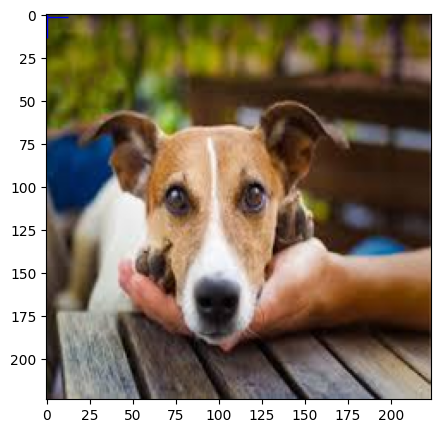

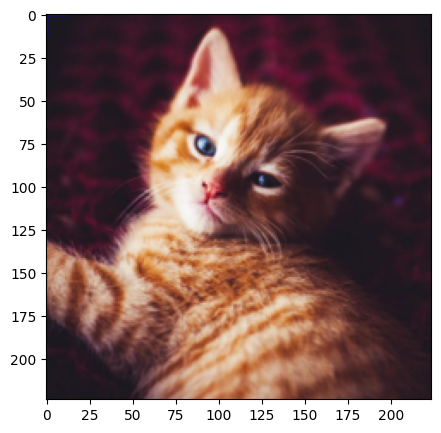

In [2]:
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import os
import pandas as pd
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import ShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import optim


# Paths
path2data = "data/train"
path2train = "data/train"
excel_path = os.path.join(path2data, "image_labels.xlsx")

# Function to create labels DataFrame and save to Excel
def create_labels_dataframe(path2train, excel_path):
    data = []
    index = 0
    for category in ['cats', 'dogs']:
        folder_path = os.path.join(path2train, category)
        for img_name in os.listdir(folder_path):
            if img_name.endswith('.jpg'):
                img_path = os.path.join(folder_path, img_name)
                label = 0 if category == 'cats' else 1  # Assign label: 0 for cats, 1 for dogs
                data.append((index, img_name, label))
                index += 1
    
    labels_df = pd.DataFrame(data, columns=['index', 'imgName', 'label'])
    labels_df.to_excel(excel_path, index=False)  # Save to Excel file
    return labels_df

# Function to load image and label
def my_load_img_labels(excel_path, id_, img_size=(224, 224)):
    labels_df = pd.read_excel(excel_path)
    img_name = labels_df["imgName"].iloc[id_]
    category = 'cats' if labels_df["label"].iloc[id_] == 0 else 'dogs'
    img_path = os.path.join(path2train, category, img_name)
    img = Image.open(img_path).resize(img_size)  # Resize image
    label = labels_df["label"].iloc[id_]
    return img, label

# Dataset class
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform=None, img_size=(224, 224)):
        self.path2labels = os.path.join(path2data, "image_labels.xlsx")
        self.labels_df = create_labels_dataframe(path2train, self.path2labels)
        self.labels = self.labels_df["label"].values
        self.img_names = self.labels_df["imgName"]
        self.ids = self.labels_df.index
        self.transform = transform
        self.img_size = img_size
        self.path2train = path2train

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        category = 'cats' if self.labels[idx] == 0 else 'dogs'
        img_path = os.path.join(self.path2train, category, img_name)
        image = Image.open(img_path).resize(self.img_size)  # Resize image
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def transformer(image):
    image = TF.to_tensor(image)
    return image

# Create dataset instances
amd_ds1 = AMD_dataset(path2data, transformer)
amd_ds2 = AMD_dataset(path2data, transformer)
print(len(amd_ds1))

# Split the dataset into training and validation sets
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices = list(range(len(amd_ds1)))  # Convert range to list
for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-" * 10)
    print(len(val_index))

# Create training and validation subsets
train_ds = Subset(amd_ds1, train_index)
print(len(train_ds))
val_ds = Subset(amd_ds2, val_index)
print(len(val_ds))

def show(img, label):
    npimg = np.array(img)
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    if label is not None:
        x = label
        plt.plot(x, 'b+', markersize=30)

plt.figure(figsize=(5, 5))
for img, label in train_ds:
    show(img, label)
    break

plt.figure(figsize=(5, 5))
for img, label in val_ds:
    show(img, label)
    break

# DataLoader
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=3, shuffle=True)

for img_b, label_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(label_b.shape)
    break

for img_b, label_b in val_dl:
    print(img_b.shape, img_b.dtype)
    label_b = label_b.type(torch.float32)
    print(label_b.shape, label_b.dtype)
    break

for x, y in train_dl:
    print(x.shape, y)
    break
for x, y in train_dl:
    print(x.shape)
    print(y.shape)

def accuracy(labels, out):
    return np.sum(out == labels) / float(len(labels))

# CNN Model
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h, w = findConv2dOutShape(H_in, W_in, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv3)
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv4)
        # compute the flatten size
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def findConv2dOutShape(H_in, W_in, conv, pool=2):  # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    H_out = np.floor((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    W_out = np.floor((W_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)
    if pool:
        H_out /= pool
        W_out /= pool
    return int(H_out), int(W_out)

# Model parameters
params_model = {
    "input_shape": (3, 224, 224),  # Changed to match image size used in dataset
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2,
}

model = Net(params_model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)
print(next(model.parameters()).device)

summary(model, input_size=(3, 224, 224), device=device.type)  # Match input size

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            running_loss += loss.item() * inputs.size(0)
            
            # Collect predictions
            preds = torch.argmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return epoch_loss, accuracy, precision, recall, f1

# Training and validation loop
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_dl, criterion, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate_model(model, val_dl, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f}")
    print(f"Val Precision: {val_precision:.4f}")
    print(f"Val Recall: {val_recall:.4f}")
    print(f"Val F1 Score: {val_f1:.4f}")
    print('-' * 20)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

